In [1]:
import numpy as np
import cv2
from skimage import measure
from scipy import ndimage
import os
import glob
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from utils import dataset, losses, metrics, misc, preprocess, segmentation_model, vizualization

misc.seed_everything(42)

In [5]:
data_dir = './new_dataset' # путь к датасету

train_image_files = glob.glob(os.path.join(data_dir, 'train', '*.jpg'))
train_mask_files = [f.replace('.jpg', '-VA.png') for f in train_image_files]
train_pairs = [(img, mask) for img, mask in zip(train_image_files, train_mask_files)]

val_image_files = glob.glob(os.path.join(data_dir, 'val', '*.jpg'))
val_mask_files = [f.replace('.jpg', '-VA.png') for f in val_image_files]
val_pairs = [(img, mask) for img, mask in zip(val_image_files, val_mask_files)]

def find_arteries_centers(mask_path):

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    labeled_mask, num_components = measure.label(binary_mask, return_num=True, connectivity=2)
    centers = []
    
    for i in range(1, num_components + 1):
        component = (labeled_mask == i)
        
        y, x = ndimage.center_of_mass(component)
        
        centers.append((int(x), int(y)))

    if len(centers) != 2:
        print(f"Предупреждение: найдено {len(centers)} артерий вместо ожидаемых 2 в {mask_path}")
    
    centers.sort(key=lambda c: c[0])
    
    return centers

def process_dataset(image_mask_pairs, output_path=None):

    results = {}
    
    for img_path, mask_path in image_mask_pairs:
        # Проверяем существование маски
        if not os.path.exists(mask_path):
            print(f"Ошибка: маска {mask_path} не найдена")
            continue
            
        # Получаем имя изображения без пути и расширения
        img_name = os.path.basename(img_path)
        
        # Находим центры артерий
        centers = find_arteries_centers(mask_path)
        
        # Сохраняем результаты
        results[img_name] = {
            'left_artery': centers[0] if len(centers) > 0 else None,
            'right_artery': centers[1] if len(centers) > 1 else None
        }
    
    if output_path:
        with open(output_path, 'w') as f:
            json.dump(results, f, indent=4)
            
        # Также создаем CSV-файл для удобства работы
        df_data = []
        for img_name, coords in results.items():
            if coords['left_artery'] and coords['right_artery']:
                df_data.append({
                    'image': img_name,
                    'left_x': coords['left_artery'][0],
                    'left_y': coords['left_artery'][1],
                    'right_x': coords['right_artery'][0],
                    'right_y': coords['right_artery'][1]
                })
                
        df = pd.DataFrame(df_data)
        csv_path = output_path.replace('.json', '.csv')
        df.to_csv(csv_path, index=False)
        print(f"Результаты сохранены в {output_path} и {csv_path}")
    
    return results


train_centers = process_dataset(train_pairs)
val_centers = process_dataset(val_pairs)

print(f"Обработано {len(train_centers)} обучающих и {len(val_centers)} валидационных изображений")

Обработано 24 обучающих и 6 валидационных изображений


In [6]:
class ArteriesDataset(Dataset):

    def __init__(self, image_paths, centers_dict, transform=None):

        self.image_paths = image_paths
        self.centers_dict = centers_dict
        self.transform = transform
        
        self.image_names = [os.path.basename(path) for path in self.image_paths]
        
        valid_indices = []
        for i, name in enumerate(self.image_names):
            if name in self.centers_dict and self.centers_dict[name]['left_artery'] and self.centers_dict[name]['right_artery']:
                valid_indices.append(i)
                
        self.image_paths = [self.image_paths[i] for i in valid_indices]
        self.image_names = [self.image_names[i] for i in valid_indices]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        centers = self.centers_dict[self.image_names[idx]]
        left_x, left_y = centers['left_artery']
        right_x, right_y = centers['right_artery']
        
        target = torch.tensor([left_x / 512, left_y / 512, right_x / 512, right_y / 512], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, target

train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ArteriesDataset(train_image_files, train_centers, transform=train_transform)
val_dataset = ArteriesDataset(val_image_files, val_centers, val_transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

print(f"Созданы датасеты: обучающий ({len(train_dataset)} изображений) и валидационный ({len(val_dataset)} изображений)")

Созданы датасеты: обучающий (24 изображений) и валидационный (6 изображений)


In [12]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights, resnet101, ResNet101_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import matplotlib.pyplot as plt
from tqdm import tqdm

class ArteriesLocalizationModel(nn.Module):

    def __init__(self, pretrained=True):
        super(ArteriesLocalizationModel, self).__init__()
        
        weights = ResNet101_Weights.DEFAULT if pretrained else None
        self.backbone = resnet101(weights=weights)
        
        # Заменяем последний полносвязный слой для предсказания 4 координат (x1, y1, x2, y2)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 4),
            nn.Sigmoid()  # Для нормализации координат в диапазоне [0, 1]
        )
        
    def forward(self, x):
        return self.backbone(x)

def euclidean_loss(pred, target):

    batch_size = pred.size(0)
    
    pred_points = pred.view(batch_size, 2, 2)
    target_points = target.view(batch_size, 2, 2)
    
    dist = torch.sqrt(torch.sum((pred_points - target_points) ** 2, dim=2))
    
    return torch.mean(dist) * 512

def train_model(model, train_loader, val_loader, epochs=30, lr=1e-4):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Используется устройство: {device}")
    
    model = model.to(device)
    
    criterion = nn.MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_euclidean': [],
        'val_euclidean': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_euclidean = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Эпоха {epoch+1}/{epochs} [Обучение]")
        for images, targets in progress_bar:
            images, targets = images.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, targets)
            euclidean = euclidean_loss(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_euclidean += euclidean.item()
            
            progress_bar.set_postfix({
                'loss': loss.item(),
                'euclidean': f"{euclidean.item():.2f} px"
            })
        
        train_loss /= len(train_loader)
        train_euclidean /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        val_euclidean = 0.0
        
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f"Эпоха {epoch+1}/{epochs} [Валидация]")
            for images, targets in progress_bar:
                images, targets = images.to(device), targets.to(device)
                
                outputs = model(images)
                
                loss = criterion(outputs, targets)
                euclidean = euclidean_loss(outputs, targets)
                
                val_loss += loss.item()
                val_euclidean += euclidean.item()
                
                progress_bar.set_postfix({
                    'loss': loss.item(),
                    'euclidean': f"{euclidean.item():.2f} px"
                })
        
        val_loss /= len(val_loader)
        val_euclidean /= len(val_loader)
        
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_euclidean'].append(train_euclidean)
        history['val_euclidean'].append(val_euclidean)
        
        print(f"Эпоха {epoch+1}/{epochs} - "
              f"Обучение: потеря={train_loss:.4f}, расстояние={train_euclidean:.2f}px | "
              f"Валидация: потеря={val_loss:.4f}, расстояние={val_euclidean:.2f}px")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'location_weights/best_location_weights.pth')
            print(f"Модель сохранена с валидационной потерей {val_loss:.4f}")
    
    model.load_state_dict(torch.load('location_weights/best_location_weights.pth'))
    
    return model, history

Используется устройство: cpu


Эпоха 1/1 [Валидация]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 17.34it/s, loss=0.0207, euclidean=99.69 px]


Эпоха 1/1 - Обучение: потеря=0.0250, расстояние=103.21px | Валидация: потеря=0.0178, расстояние=90.06px
Модель сохранена с валидационной потерей 0.0178


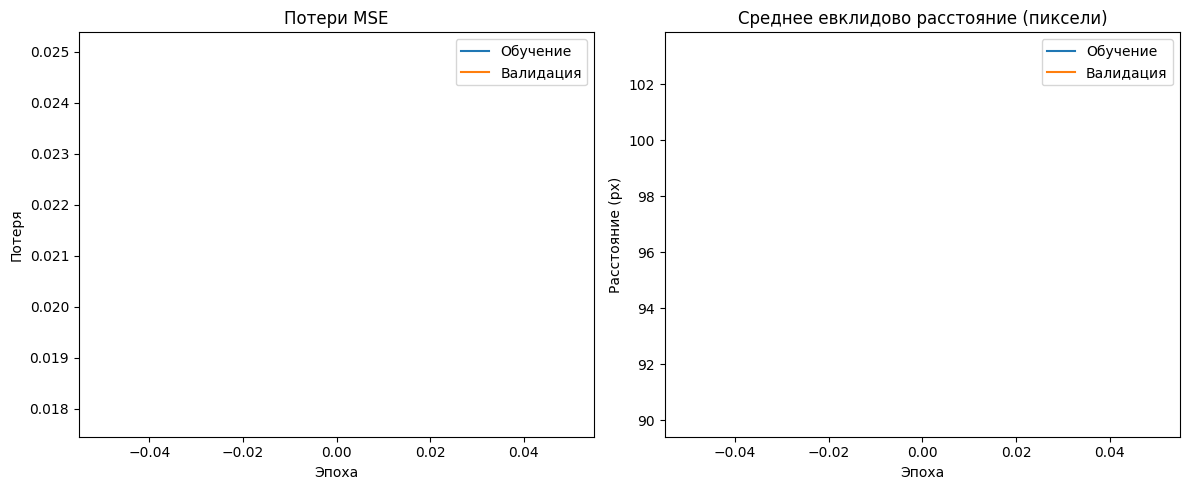

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ArteriesLocalizationModel(pretrained=True).to(device)
model.load_state_dict(torch.load('location_weights/best_arteries_model_ants.pth', map_location=device))
trained_model, history = train_model(model, train_loader, val_loader, epochs=1, lr=0.0001)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Обучение')
plt.plot(history['val_loss'], label='Валидация')
plt.title('Потери MSE')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_euclidean'], label='Обучение')
plt.plot(history['val_euclidean'], label='Валидация')
plt.title('Среднее евклидово расстояние (пиксели)')
plt.xlabel('Эпоха')
plt.ylabel('Расстояние (px)')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()